In [12]:
# set-up
library(dplyr)
library(ggplot2)
library(ggsignif)
library(reshape2)
library(cowplot)
library(ggpubr)
options(stringsAsFactors=F)
options(warn = -1) 
DAT <- read.csv("noQC_no_pop_specific_missingness.csv")
dat_saliva <- DAT[DAT$predictedTissue %in% c("Saliva", "Blood PBMC", "Blood WB"),]
DAT <- dat_saliva
DAT$predictedTissue <- as.factor(DAT$predictedTissue)
# Choose colours
popColours <- c("Himba" = rgb(185/255, 70/255, 99/255),  # red
                "KHS" = rgb(151/255, 80/255, 161/255),  # purple/magenta
                "Baka" = rgb(188/255, 125/255, 57/255))  # orange

# Define metrics
ageAccelMetrics <- c("Age" = "Age",
                     "AgeAccelerationResidual" = "Horvath 2013 residual" ,
                     "IEAA" = "Intrinsic EAA\nbased on Horvath 2013",
                     "EEAA" = "Extrinsic EAA\nbased on Hannum et al. 2013",
                     "AgeAccelerationResidualHannum" =  "Hannum et al. 2013 residual",
                      "IEAA.Hannum" = "Intrinsic EAA based\non Hannum et al. 2013",
                      "AgeAccelPheno" = "PhenoAge-based acceleration",
                     "DNAmGrimAgeBasedOnRealAgeAdjAge" = "GrimAge-based acceleration,\nadjusted for true age" ,
                     "DNAmGrimAgeBasedOnPredictedAgeAdjAge" = "GrimAge-based acceleration,\nadjusted for predicted age",
                     "DNAmTLAdjAge" = "DNAm-based telomere length\nestimate, adjusted for true age" )

colnames(DAT)
###EAS with acceleration metrics in main fig
EAA_main <- c("Age", "IEAA", "EEAA", "AgeAccelPheno", "DNAmGrimAgeBasedOnPredictedAgeAdjAge", "DNAmTLAdjAge")
DAT <- DAT[,colnames(DAT) %in% c("Pop", "SID", EAA_main)]

###EAS with acceleration metrics in supp fig 9, uncomment for this
# EAA_supp <- c("AgeAccelerationResidual", "AgeAccelerationResidualHannum", "IEAA.Hannum", "DNAmGrimAgeBasedOnRealAgeAdjAge")
# DAT <- DAT[,colnames(DAT) %in% c("Pop", "SID", EAA_supp)]

head(DAT)
# Ensure the pop_label matches the population colors
DAT$pop_label <- factor(DAT$Pop, levels = names(popColours))

# Create a combined dataset for all metrics
all_dat <- list()

# Iterate through each metric in the EAA_main list  ORO EAA_supp
for (metric in EAA_main) {
#for (metric in EAA_supp) {
  for (pop in c("Himba", "KHS", "Baka")) {
    # Read the EAS data for the current population
    EAS_df <- read.csv(paste0(pop, "_EAS_using_", pop, "_model.csv"), header = TRUE, row.names = 1)
    
    # Handle any specific data corrections for Himba population
    if (pop == "Himba") {
      EAS_df["HMB181_2", ] <- EAS_df["HMB181", ]
      rownames(EAS_df)[rownames(EAS_df) == "HMB494-2"] <- "HMB494.2"
    }
    
    # Filter the dataset for the current population and metric
    tmp_dat <- DAT[DAT$Pop == pop, c("SID", metric)]
    
    # Ensure correct matching for EAS data by summing over the rows corresponding to SID
    EAS <- as.data.frame(apply(EAS_df[tmp_dat$SID, ], MARGIN = 1, FUN = sum, na.rm = TRUE))
    
    # Combine the temporary dataset with the EAS data
    tmp_dat <- cbind(tmp_dat, EAS)
    
    # Rename columns for clarity
    colnames(tmp_dat)[2:3] <- c("metric", "EAS")
    
    # Add population label
    tmp_dat$pop_label <- pop
    
    # Assign the longer name from ageAccelMetrics
    tmp_dat$metric_label <- ageAccelMetrics[metric]  # Map the short metric name to the full label

    # Append the combined data to the all_dat list
    all_dat[[paste0(pop, "_", metric)]] <- tmp_dat
  }
}

# Combine all data into a single dataframe
combined_dat <- do.call(rbind, all_dat)




combined_dat <- combined_dat %>%
  mutate(
    pop_label_ = case_when(
      pop_label == "Himba" ~ "Himba",
      pop_label == "KHS" ~ "\u2021Khomani San",  # Use expression for Khomani San
      pop_label == "Baka" ~ "Baka",
      TRUE ~ NA_character_
    )
  )

unique(combined_dat$metric_label)


[1] "Pop"                                     
  [2] "SID"                                     
  [3] "OriginalOrderInBatch"                    
  [4] "Plate_Number"                            
  [5] "Well_Address"                            
  [6] "Sentrix_ID"                              
  [7] "Sentrix_Position"                        
  [8] "Age"                                     
  [9] "Tissue"                                  
 [10] "Sex"                                     
 [11] "Basename"                                
 [12] "Collection.Date"                         
 [13] "Row"                                     
 [14] "Col"                                     
 [15] "Comment"                                 
 [16] "noMissingPerSample"                      
 [17] "meanMethBySample"                        
 [18] "minMethBySample"                         
 [19] "maxMethBySample"                         
 [20] "corSampleVSgoldstandard"                 
 [21] "meanAbsDifferenceSampleVSgoldstandard"   
 [22] "meanXchromosome"                         
 [23] "Alcohol"                                 
 [24] "Body.Mass.Index"                         
 [25] "Body.Fat.."                              
 [26] "HDL.Cholesterol"                         
 [27] "Smoking"                                 
 [28] "Waist.Hip.Ratio"                         
 [29] "DNAmGait_noAge"                          
 [30] "DNAmGrip_noAge"                          
 [31] "DNAmVO2max"                              
 [32] "DNAmGait_wAge"                           
 [33] "DNAmGrip_wAge"                           
 [34] "DNAmFEV1_wAge"                           
 [35] "DNAmFEV1_noAge"                          
 [36] "CD8T"                                    
 [37] "CD4T"                                    
 [38] "NK"                                      
 [39] "Bcell"                                   
 [40] "Mono"                                    
 [41] "Gran"                                    
 [42] "PlasmaBlast"                             
 [43] "CD8pCD28nCD45RAn"                        
 [44] "CD8.naive"                               
 [45] "CD4.naive"                               
 [46] "PropNeuron"                              
 [47] "predictedTissue"                         
 [48] "ProbabilityFrom.X.Vasc.Endoth.Umbilical."
 [49] "ProbabilityFrom.Ape.WB"                  
 [50] "ProbabilityFrom.Blood.CD4.Tcells"        
 [51] "ProbabilityFrom.Blood.CD4.CD14"          
 [52] "ProbabilityFrom.Blood.Cell.Types"        
 [53] "ProbabilityFrom.Blood.Cord"              
 [54] "ProbabilityFrom.Blood.PBMC"              
 [55] "ProbabilityFrom.Blood.WB"                
 [56] "ProbabilityFrom.Bone"                    
 [57] "ProbabilityFrom.Brain.Cerebellar"        
 [58] "ProbabilityFrom.Brain.CRBLM"             
 [59] "ProbabilityFrom.Brain.FCTX"              
 [60] "ProbabilityFrom.Brain.Occipital.Cortex"  
 [61] "ProbabilityFrom.Brain.PONS"              
 [62] "ProbabilityFrom.Brain.Prefr.CTX"         
 [63] "ProbabilityFrom.Brain.TCTX"              
 [64] "ProbabilityFrom.Breast"                  
 [65] "ProbabilityFrom.Breast.NL"               
 [66] "ProbabilityFrom.Buccal"                  
 [67] "ProbabilityFrom.Cartilage.Knee"          
 [68] "ProbabilityFrom.Colon"                   
 [69] "ProbabilityFrom.Dermal.fibroblast"       
 [70] "ProbabilityFrom.Epidermis"               
 [71] "ProbabilityFrom.Fat.Adip"                
 [72] "ProbabilityFrom.Gastric"                 
 [73] "ProbabilityFrom.GlialCell"               
 [74] "ProbabilityFrom.Head.Neck"               
 [75] "ProbabilityFrom.Heart"                   
 [76] "ProbabilityFrom.Kidney"                  
 [77] "ProbabilityFrom.Liver"                   
 [78] "ProbabilityFrom.Liver."                  
 [79] "ProbabilityFrom.Lung"                    
 [80] "ProbabilityFrom.MSC"                     
 [81] "ProbabilityFrom.Muscle"                  
 [82] "ProbabilityFrom.Neuron"   

,Pop,SID,Age,AgeAccelPheno,DNAmGrimAgeBasedOnPredictedAgeAdjAge,DNAmTLAdjAge,IEAA,EEAA
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,KHS,SA003,22,-1.6812402,-4.363193,-0.25272416,0.1754877,1.267069
2,KHS,SA004,75,12.2737363,2.580612,-0.26361018,-0.7287323,5.369164
3,KHS,SA009,67,-6.2465091,-4.384234,0.47259728,-11.1644254,-6.720243
4,KHS,SA010,21,-4.0859634,-4.715330,0.06472526,-6.7830259,-2.548534
5,KHS,SA017,65,-4.4330170,-6.337383,0.28132859,-2.7626717,-7.159269
6,KHS,SA018,56,0.2616899,-1.846405,0.06039677,0.8612457,-5.108593


[1] "Age"                                                        
[2] "Intrinsic EAA\nbased on Horvath 2013"                       
[3] "Extrinsic EAA\nbased on Hannum et al. 2013"                 
[4] "PhenoAge-based acceleration"                                
[5] "GrimAge-based acceleration,\nadjusted for predicted age"    
[6] "DNAm-based telomere length\nestimate, adjusted for true age"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


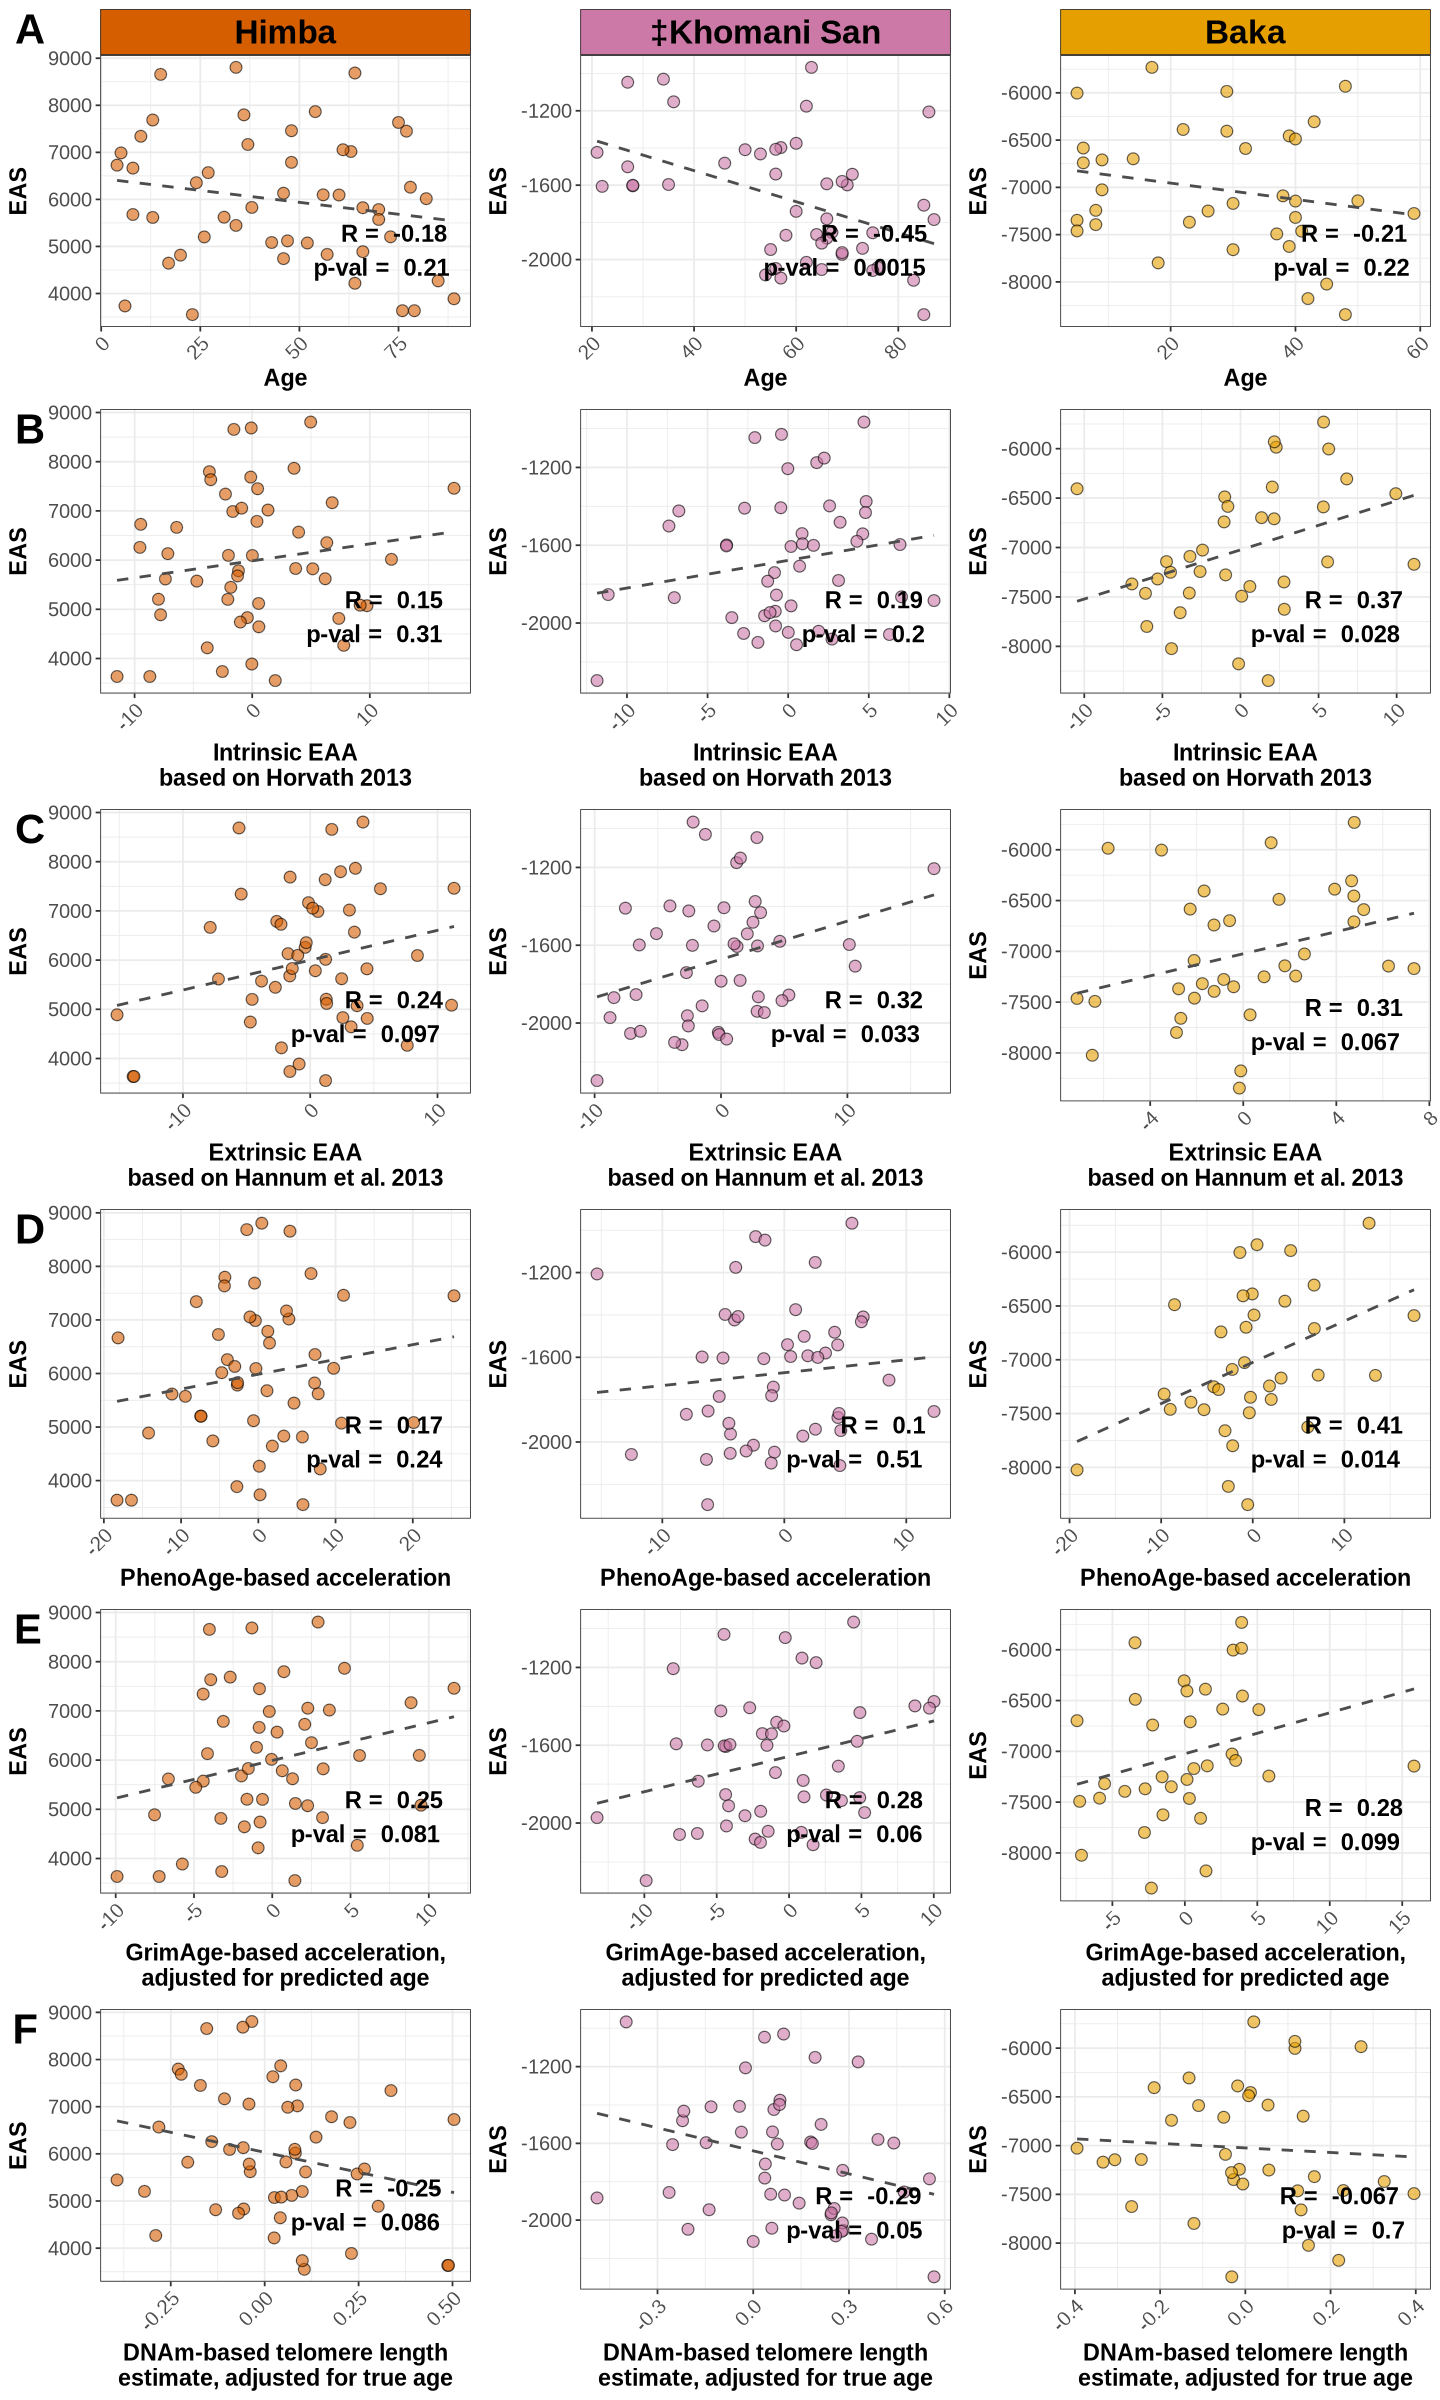

In [13]:
# Create individual plots for each population for the 'Age' metric
#######MAIN FIGURE 7, see next code block for supp figure 9
plot_list <- list()
pop_plot_list <- list()  # Initialize list to store plots

popColours <- c("Himba" = rgb(213/255, 94/255, 0/255), # red
                "KHS" = rgb(204/255, 121/255, 167/255), # purple/magenta
                "Baka" = rgb(230/255, 159/255, 0/255))


for (pop in unique(combined_dat$pop_label)) {
  # Subset the data for this population and the 'Age' metric
  age_dat <- combined_dat[combined_dat$pop_label == pop & combined_dat$metric_label == "Age",]
  # Handle special case for the "KHS" population
  if (pop == "KHS") {
    pop_label_ <- "\u2021Khomani San"
      pop_label <- "KHS"
  } else {
    pop_label_ <- pop 
    pop_label <- pop # Use the population name as is
  }
  
  # Perform the correlation test for 'Age' vs EAS for the current population
  cor_test <- cor.test(age_dat$metric, age_dat$EAS, method = "pearson")
  
  # Create the plot for the 'Age' metric
  age_plot <- ggplot(age_dat, aes(x = metric, y = EAS)) +
  geom_point(size = 3, shape = 21, color = "black", aes(fill = pop_label), alpha=0.6) +
    labs(x = "Age", y = "EAS") +
    theme_bw() + 
    geom_smooth(method = "lm", se = FALSE, linetype = "dashed", linewidth = 0.8, colour = "grey30") +
    facet_wrap(~ pop_label_, scales = "free_x", ncol = 1) +  # Use pop_label directly for faceting
    theme(
      legend.position = "none",
      axis.title.y = element_text(size = 14, face = "bold"),
      axis.title.x = element_text(size = 14, face = "bold"),
      axis.text.x = element_text(size=12,angle = 45, hjust = 1),
      axis.text.y = element_text(size = 12),
      strip.text.y = element_blank(),
      strip.text = element_text(size = 12, face = "bold"),
      strip.text.x = element_text(size = 20, colour = "black"),
      # Set the strip background color based on population
      strip.background = element_rect(fill = popColours[pop_label])
    ) +
    scale_colour_manual(values = popColours)  +
    scale_fill_manual(values = popColours)  # Ensures color mapping for points
  
  # Add the annotation dynamically based on the population-specific range
  age_plot <- age_plot + 
    geom_text(
      data = data.frame(x = Inf, y = -Inf, label = paste("R = ", signif(cor_test$estimate, 2), "\n", "p-val = ", signif(cor_test$p.value, 2))),
      aes(x = x, y = y, label = label),
      vjust = -1, hjust = 1.15, fontface = "bold", size = 5, colour = "black", inherit.aes = FALSE
    )
  
  # Store the plot in the list
  pop_plot_list[[pop]] <- age_plot
}


# Combine all the population plots for 'Age' into a single plot using plot_grid from cowplot
combined_age_plot <- cowplot::plot_grid(plotlist = pop_plot_list, ncol = 3, labels = NULL, align = "v")

# Store the 'Age' plot in the plot_list
plot_list[["Age"]] <- combined_age_plot

# Loop through each metric (including 'Age' and other metrics)
for (metric in unique(combined_dat[!combined_dat$metric_label== "Age","metric_label"])) {
  
  # Create an empty list to store population-specific plots for the current metric
  pop_plot_list <- list()
  
  # Loop through each population
  for (pop in unique(combined_dat$pop_label)) {
    
    # Subset the data for the current population and metric
    pop_data <- combined_dat[combined_dat$pop_label == pop & combined_dat$metric_label == metric,]
    
    # Perform the correlation test for the current population's data
    cor_test <- cor.test(pop_data$metric, pop_data$EAS)
    
    # Create the plot for the current metric and population
    pop_plot <- ggplot(pop_data, aes(x = metric, y = EAS)) +
  geom_point(size = 3, shape = 21, color = "black", aes(fill = pop_label), alpha=.6) +    
      labs(x = metric, y = "EAS") +  # Update the x-axis label to reflect the metric name
      theme_bw() + 
      geom_smooth(method = "lm", se = FALSE, linetype = "dashed", linewidth = 0.8, colour = "grey30") +
      facet_wrap(~ pop_label_, scales = "free_x", ncol = 1) +  # Facet by population and metric with free scales
      theme(plot.title = element_blank(),
            legend.position = "none",  # Remove legend
            axis.title.y = element_text(size = 14, face = "bold"),
            axis.title.x = element_text(size = 14, face = "bold"),
            axis.text.x = element_text(size = 12, angle = 45, hjust = 1),  # Show x-axis labels
            axis.text.y = element_text(size = 12),  # Adjust y-axis text size
            strip.text.y = element_blank(),  # Remove the y strip label for better formatting
            strip.text = element_blank(),  # Bold text for the strip labels (pop_label)
            strip.text.x = element_blank(), 
            # Remove strip background for metric plots (no pop labels)
            strip.background = element_blank() 
      ) + theme(plot.title = element_blank()) +
      scale_colour_manual(values = popColours) +  # Color points by pop_label using popColours
    scale_fill_manual(values = popColours)+
  geom_text(face="bold", data = data.frame(x = Inf, 
                                y = -Inf),  # Adjust y position
              label = paste("R = ", signif(cor_test$estimate, 2), "\n", 
                            "p-val = ", signif(cor_test$p.value, 2)),  face="bold",
              aes(x = x, y = y, label = label), 
              fontface = "bold", size = 5, colour = "black",  
              vjust = -1, hjust = 1.2) 
    # Store the plot for the current population in the list
    pop_plot_list[[pop]] <- pop_plot
  }
  
  # Combine all population-specific plots for the current metric into a single plot row
  combined_metric_plot <- cowplot::plot_grid(plotlist = pop_plot_list, ncol = 3, align = "v")
  
  # Store the combined metric plot in the main plot list
  plot_list[[metric]] <- combined_metric_plot
}

# Combine all the metric plots into a single plot grid (one row for each metric)
final_combined_plot <- cowplot::plot_grid(plotlist = plot_list, ncol = 1, labels = "AUTO", label_size = 25, align = "v")

# Set plot dimensions
options(repr.plot.width = 12, repr.plot.height = 20)

# Print the final combined plot
print(final_combined_plot)



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


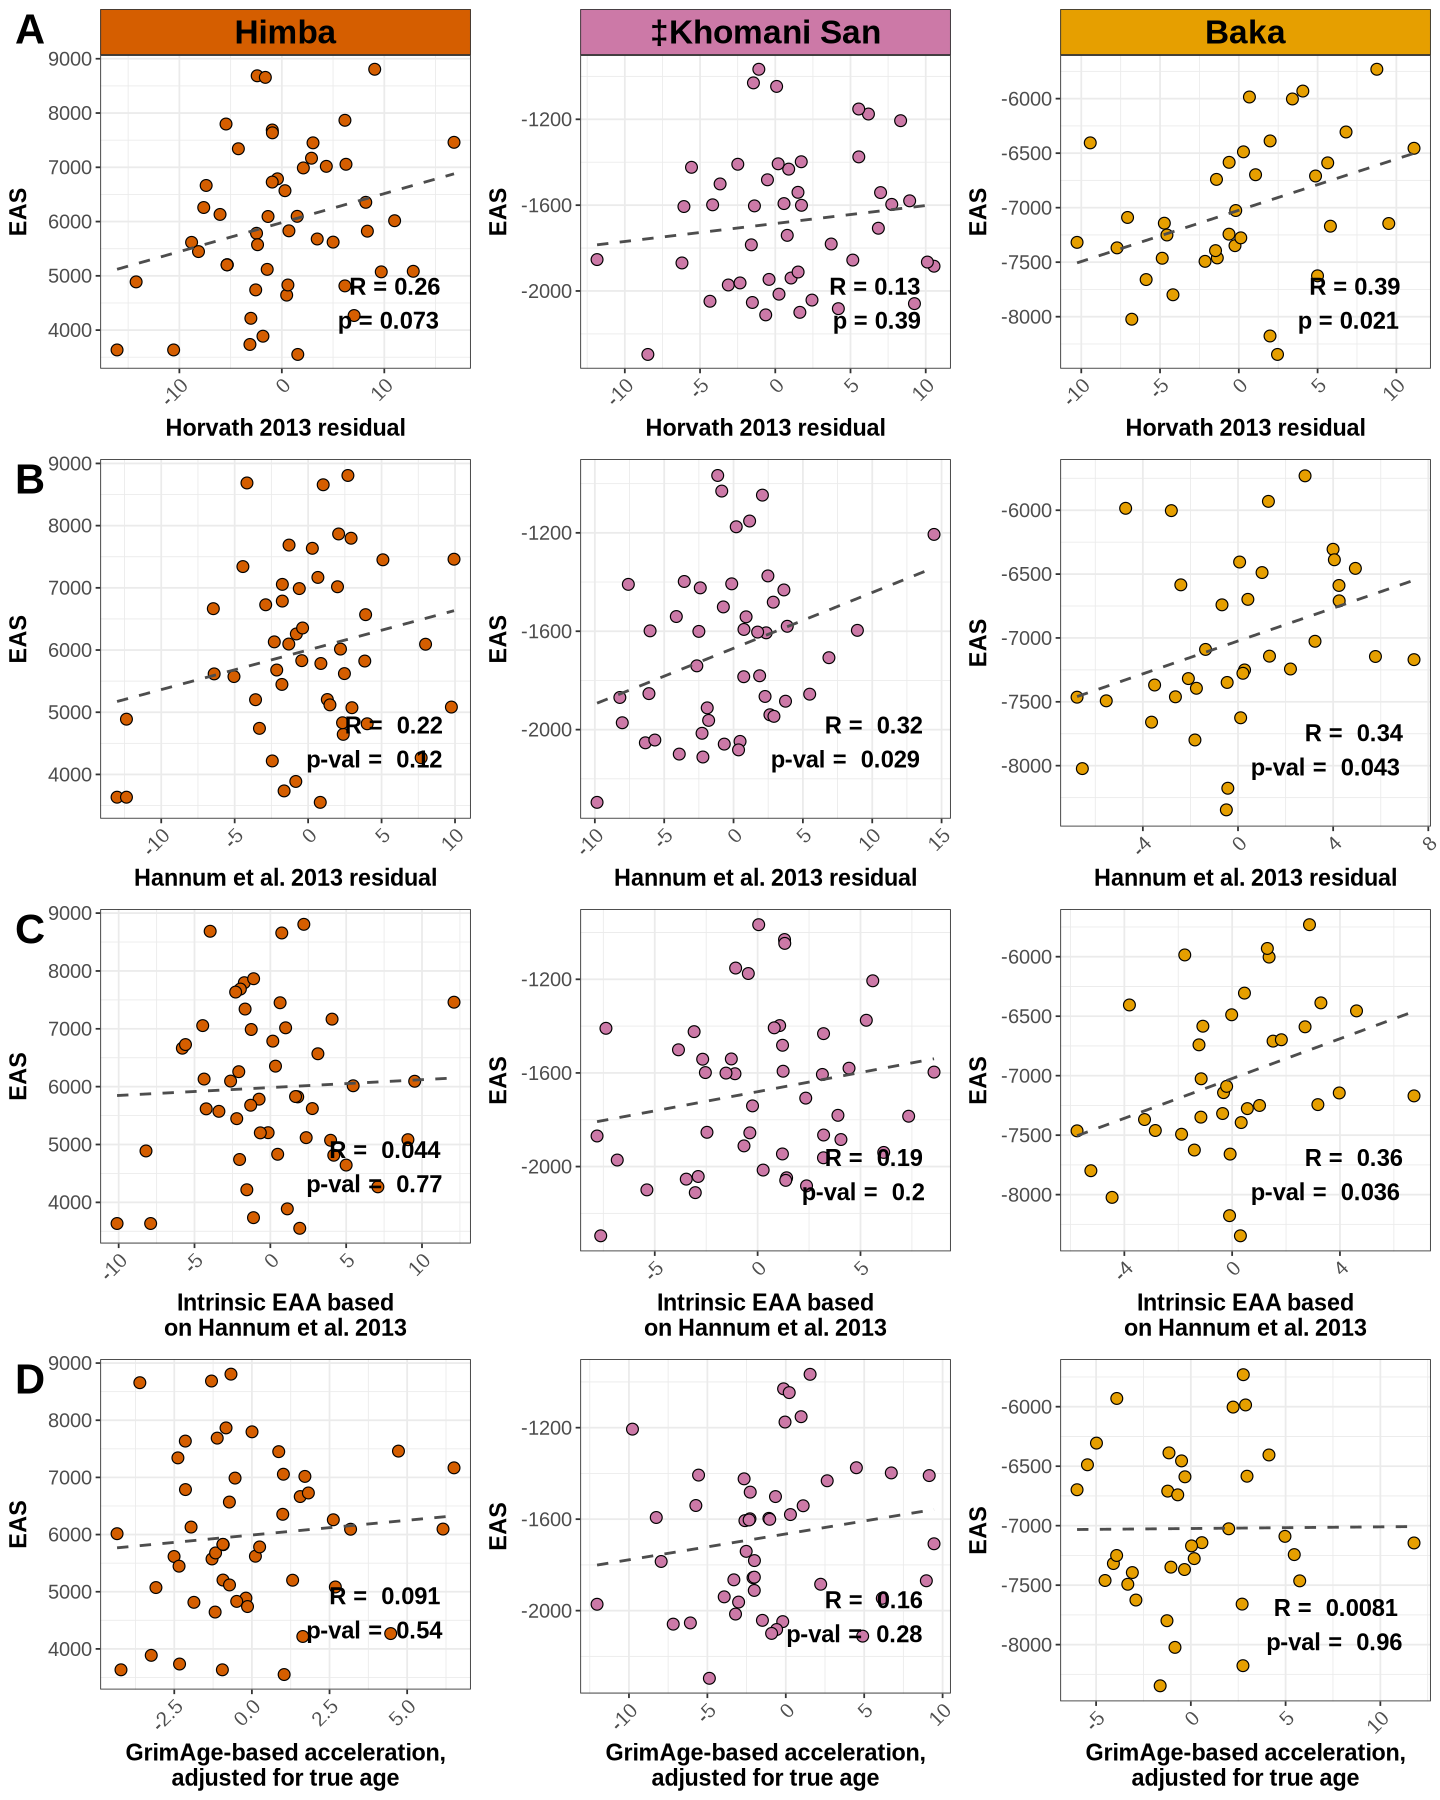

In [11]:
# Create individual plots for each population for the 'Age' metric
# Define the population colors
######SUPP FIGURE CODE###
popColours <- c("Himba" = rgb(213/255, 94/255, 0/255), # red
                "KHS" = rgb(204/255, 121/255, 167/255), # purple/magenta
                "Baka" = rgb(230/255, 159/255, 0/255))


# Initialize lists to store plots
pop_plot_list <- list()
 plot_list <- list()
for (pop in unique(combined_dat$pop_label)) {
  # Subset the data for this population and the 'Horvath 2013 residual' metric
  age_dat <- combined_dat[combined_dat$pop_label == pop & combined_dat$metric_label == "Horvath 2013 residual", ]
  
  # Handle special case for the "KHS" population
  if (pop == "KHS") {
    pop_label_ <- "\u2021Khomani San"
    pop_label <- "KHS"
  } else {
    pop_label_ <- pop 
    pop_label <- pop
  }
  
  # Perform the correlation test for 'Horvath 2013 residual' vs EAS for the current population
  cor_test <- cor.test(age_dat$metric, age_dat$EAS, method = "pearson")
  
  # Create the plot
  age_plot <- ggplot(age_dat, aes(x = metric, y = EAS)) +
  geom_point(size = 3, shape = 21, color = "black", aes(fill = pop_label)) +    labs(x = "Horvath 2013 residual", y = "EAS") +
    theme_bw() +
    geom_smooth(method = "lm", se = FALSE, linetype = "dashed", linewidth = 0.8, colour = "grey30") +
    facet_wrap(~ pop_label_, scales = "free_x", ncol = 1) +  # Use pop_label directly for faceting
    theme(
      legend.position = "none",
      axis.title.y = element_text(size = 14, face = "bold"),
      axis.title.x = element_text(size = 14, face = "bold"),
      axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
      axis.text.y = element_text(size = 12),
      strip.text.y = element_blank(),
      strip.text = element_text(size = 12, face = "bold"),
      strip.text.x = element_text(size = 20, colour = "black"),
      # Set the strip background color based on population
      strip.background = element_rect(fill = popColours[pop_label])
    ) +
    scale_colour_manual(values = popColours) +
    scale_fill_manual(values = popColours)# Ensures color mapping for points
  
  # Add dynamic annotation for R and p-value
  age_plot <- age_plot + 
    geom_text(
      data = data.frame(
        x = max(age_dat$metric, na.rm = TRUE), 
        y = min(age_dat$EAS, na.rm = TRUE), 
        label = paste0("R = ", signif(cor_test$estimate, 2), "\n", "p = ", signif(cor_test$p.value, 2))
      ),
      aes(x = x, y = y, label = label),
      hjust = 1.15, vjust = -0.5, fontface = "bold", size = 5, inherit.aes = FALSE
    )
  
  # Store the plot in the list
  pop_plot_list[[pop]] <- age_plot
}

# Combine all the population plots for 'Age' into a single plot using plot_grid from cowplot
combined_age_plot <- cowplot::plot_grid(plotlist = pop_plot_list, ncol = 3, labels = NULL, align = "v")

# Store the 'Age' plot in the plot_list
plot_list[["Age"]] <- combined_age_plot

# Loop through each metric (including 'Age' and other metrics)
for (metric in unique(combined_dat[!combined_dat$metric_label== "Horvath 2013 residual","metric_label"])) {
  
  # Create an empty list to store population-specific plots for the current metric
  pop_plot_list <- list()
  
  # Loop through each population
  for (pop in unique(combined_dat$pop_label)) {
    
    # Subset the data for the current population and metric
    pop_data <- combined_dat[combined_dat$pop_label == pop & combined_dat$metric_label == metric,]
    
    # Perform the correlation test for the current population's data
    cor_test <- cor.test(pop_data$metric, pop_data$EAS)
    
    # Create the plot for the current metric and population
    pop_plot <- ggplot(pop_data, aes(x = metric, y = EAS)) +
  geom_point(size = 3, shape = 21, color = "black", aes(fill = pop_label)) +
      labs(x = metric, y = "EAS") +  # Update the x-axis label to reflect the metric name
      theme_bw() + 
      geom_smooth(method = "lm", se = FALSE, linetype = "dashed", linewidth = 0.8, colour = "grey30") +
      facet_wrap(~ pop_label_, scales = "free_x", ncol = 1) +  # Facet by population and metric with free scales
      theme(plot.title = element_blank(),
            legend.position = "none",  # Remove legend
            axis.title.y = element_text(size = 14, face = "bold"),
            axis.title.x = element_text(size = 14, face = "bold"),
            axis.text.x = element_text(size = 12, angle = 45, hjust = 1),  # Show x-axis labels
            axis.text.y = element_text(size = 12),  # Adjust y-axis text size
            strip.text.y = element_blank(),  # Remove the y strip label for better formatting
            strip.text = element_blank(),  # Bold text for the strip labels (pop_label)
            strip.text.x = element_blank(), 
            # Remove strip background for metric plots (no pop labels)
            strip.background = element_blank() 
      ) + theme(plot.title = element_blank()) +
      scale_fill_manual(values = popColours) +
      scale_colour_manual(values = popColours) +  # Color points by pop_label using popColours
    
  geom_text(face="bold", data = data.frame(x = Inf, 
                                y = -Inf),  # Adjust y position
              label = paste("R = ", signif(cor_test$estimate, 2), "\n", 
                            "p-val = ", signif(cor_test$p.value, 2)),  face="bold",
              aes(x = x, y = y, label = label), 
              fontface = "bold", size = 5, colour = "black",  
              vjust = -1, hjust = 1.2) 
    # Store the plot for the current population in the list
    pop_plot_list[[pop]] <- pop_plot
  }
  
  # Combine all population-specific plots for the current metric into a single plot row
  combined_metric_plot <- cowplot::plot_grid(plotlist = pop_plot_list, ncol = 3, align = "v")
  
  # Store the combined metric plot in the main plot list
  plot_list[[metric]] <- combined_metric_plot
}

# Combine all the metric plots into a single plot grid (one row for each metric)
final_combined_plot <- cowplot::plot_grid(plotlist = plot_list, ncol = 1, labels = "AUTO", label_size = 25, align = "v")

# Set plot dimensions
options(repr.plot.width = 12, repr.plot.height = 15)

# Print the final combined plot
print(final_combined_plot)
